In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
#disable warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,  inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
#checking names of tables contained in sql database
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


['measurement', 'station']

In [8]:
#creating object for measurement and station
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

In [9]:
#setting up inspector and confirming table names
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [10]:
# Get a list of column names and types in measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types in station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

### The following analysis extracts the precipitation from the last 12 months of the SQL database and plots the daily precipitation and then prints the total monthly precipitation calculated from the data.  The second plot was not requested in the readme file but the starter code seemed to ask for the monthly average so did both.


In [87]:
#Analysis of precipitation data to find the maximum date in the sheet.
sel = [ Measurement.date, Measurement.prcp] #pulling only date and precipitation.
weather_data = session.query(*sel).all() 
session.close()

max_date = dt.date(1900,1,1) #need this as dummy for starting to analyze the data.  If this was returned as max date
                                #would have to set as lower number.
for record in weather_data:
    (ME_date, ME_Prec) = record
    if ME_date > str(max_date):
        max_date = ME_date  
    

In [88]:
#finding last twelve months in database
YMD = max_date.split('-')
max_date = dt.date(int(YMD[0]),int(YMD[1]),int(YMD[2]))
min_date = max_date - dt.timedelta(days=365)
print(f"End date of database (most recent year): {max_date}")
print(f"Start date for 12 months earlier: {min_date}")

End date of database (most recent year): 2017-08-23
Start date for 12 months earlier: 2016-08-23


In [92]:
#the past 12 months includes partial months so difficult to work with. Instead of partial months going from 
#Aug 2016 to July 2017 to have 12 even months.
# max_date = '2017-07-31'
# min_date = '2016-08-01'

#opening query to extract information from both tables 
#sel list is date and precipitation
weather_filter = session.query(*sel).\
    filter((Measurement.date <= max_date)& (Measurement.date >= min_date)).all()
session.close()


#creating dataframe with information as dictated in directions.
precip_df = pd.DataFrame(columns = ["Date","Precip"])
for record in weather_filter:
    (ME_date, ME_Prec) = record
    precip_df = precip_df.append({"Date":ME_date, "Precip":ME_Prec}, ignore_index = True)
precip_df.dropna()
precip_df = precip_df.set_index("Date")
precip_df.sort_index(inplace=True)
precip_df

,Precip
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [93]:
#dataframe includes data from many stations. Therefore perform groupby on date and then average for day of all stations.

# precip_groupby = precip_df.groupby("Date")
# precip_group_series = precip_groupby["Precip"].mean()
# precip_group_df = pd.DataFrame({'Date':precip_group_series.index, 'Precip':precip_group_series.values})
# precip_group_df = precip_group_df.set_index('Date')
# precip_group_df.sort_index(inplace=True)
# precip_group_df



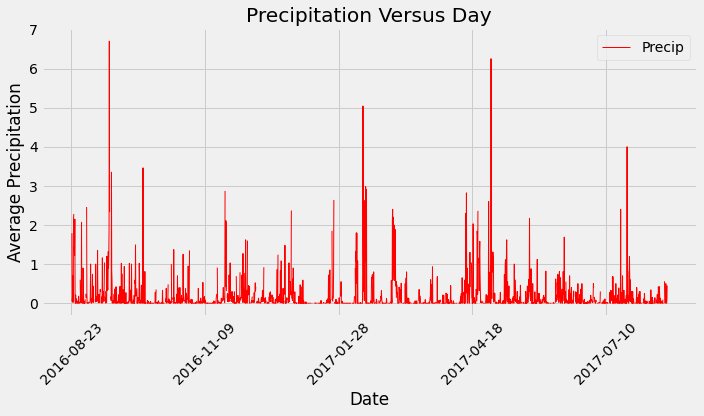

In [94]:
#creating plot of daily average precipitation.  Using Datafram plot method.
precip_df.plot(kind="line", color = "r", figsize=(10,6),lw=1, title = "Precipitation Versus Day")
plt.xlabel("Date")
plt.ylabel("Average Precipitation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [95]:
#dataframe includes data from many stations. Therefore perform groupby on date and then average for day of all stations.

precip_groupby = precip_df.groupby("Date")
precip_group_series = precip_groupby["Precip"].mean()
precip_group_df = pd.DataFrame({'Date':precip_group_series.index, 'Precip':precip_group_series.values})
precip_group_df = precip_group_df.set_index('Date')
precip_group_df.sort_index(inplace=True)
precip_group_df


,Precip
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


In [96]:
#Extracting Month and year from date and placing in dataframe.  To help in finding monthly sum.
date_series = precip_group_df.index.to_series()
precip_group_df["Month"]=[int((precip_group_df.index[i]).split('-')[1]) for i in range(0,len(date_series))]
precip_group_df["Year"]=[int((precip_group_df.index[i]).split('-')[0]) for i in range(0,len(date_series))]


In [97]:
#using group by to find total precip for month.
precip_groupby = precip_group_df.groupby(["Year","Month"])
precip_monthly_average = precip_groupby["Precip"].sum()
precip_monthly_average

Year  Month
2016  8        3.572143
      9        8.401000
      10       3.730667
      11       3.912238
      12       6.169286
2017  1        2.347952
      2        6.321881
      3        4.894500
      4        9.455619
      5        4.579833
      6        3.597119
      7        4.120452
      8        1.394333
Name: Precip, dtype: float64

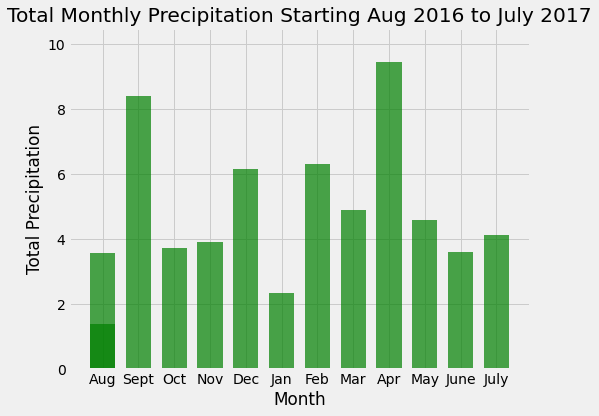

In [98]:
#gettign data for plot
x_data = [precip_monthly_average.index[i][1] for i in range(0,len(precip_monthly_average))] #extracting month into series
y_data = [round(precip_monthly_average[i],2) for i in range(0,len(precip_monthly_average))] #extracting precip into series

#creating month association dictionnary to use name of month rather than number in plot.
Month_Assoc = [(1, 'Jan'), (2, 'Feb'), (3,'Mar'), (4, 'Apr'), (5,'May'),(6,'June'),
              (7, 'July'),(8,'Aug'),(9,'Sept'),(10,'Oct'),(11,'Nov'),(12,'Dec')]

x_data_month = []
#Creating list of months by name in order of x_data
for i in range(0,len(x_data)):
    for j in range(0,len(Month_Assoc)):
        if x_data[i] == Month_Assoc[j][0]:
            x_data_month.append(Month_Assoc[j][1])
            break

plt.figure(figsize=(8,6)) #10 inches wide by 4" tall

plt.bar(x_data_month, y_data, color='g', width = 0.7, alpha=0.7, align="center") #alpha is how transparent bars are
plt.ylim(0, 10.5)

plt.title("Total Monthly Precipitation Starting Aug 2016 to July 2017")
plt.xlabel("Month")
plt.ylabel("Total Precipitation")

plt.tight_layout() #tight layout helps to arrange the graph to look nicer

plt.show()

In [99]:
print("Summary Statistics for Precipitation Date\n")

print(precip_df["Precip"].describe())

Summary Statistics for Precipitation Date

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precip, dtype: float64


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
